# Player Market Value Prediction: Applied ML 2025 Final Project

This `v3` notebook explores feature selection techniques to improve our neural network model.


In [14]:
# Import libraries and utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
import tensorflow as tf

from src.utils import (load_all, aggregate_player_stats, get_latest_valuation,
                      merge_player_data, fillna_and_scale, encode_categorical,
                      scatter_actual_vs_pred, compute_age)

pd.set_option('display.max_columns', 100)


## 1. Data Loading
Load the raw tables from `data/` using the helper utilities.

In [15]:
data = load_all()
# Example: print available tables
for name, df in data.items():
    print(f'{name}: {df.shape}')


appearances: (1706806, 13)
clubs: (439, 17)
club_games: (148052, 11)
competitions: (44, 11)
games: (74026, 23)
game_events: (1035043, 10)
game_lineups: (2191911, 10)
players: (32601, 23)
player_valuations: (496606, 5)
transfers: (79646, 10)


## 2. Preprocessing and Feature Selection
We create the main feature table, encode categoricals, and use a gradient boosting
model to rank feature importances.

In [22]:
# Aggregate stats and merge into a single DataFrame
stats      = aggregate_player_stats(data['appearances'])
latest_val = get_latest_valuation(data['player_valuations'])
main_df    = merge_player_data(data['players'], stats, latest_val)
main_df    = main_df.drop(columns='market_value_in_eur_x') \
                    .rename(columns={'market_value_in_eur_y': 'market_value_in_eur'})

print("Before age, columns:", main_df.columns.tolist())
main_df = compute_age(main_df)
print("After age, columns: ", main_df.columns.tolist())

# ─── DROP any rows where the target is NaN ─────────────────────────────────────
main_df = main_df.dropna(subset=['market_value_in_eur'])

# Example numeric + categorical columns
num_cols = ['age', 'n_games', 'total_yellow', 'total_red', 'height_in_cm']
cat_cols = ['position', 'country_of_citizenship']

# Fill NA and scale numeric features
X_num, scaler = fillna_and_scale(main_df, num_cols)

# One-hot encode categoricals
df_cat, encoder = encode_categorical(main_df, cat_cols)

# Combine into a single feature matrix
X_full = np.hstack([X_num, df_cat.values])

# Now y has no NaNs, so gradient boosting will accept it
y = main_df['market_value_in_eur']


Before age, columns: ['player_id', 'first_name', 'last_name', 'name', 'last_season', 'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name', 'image_url', 'url', 'current_club_domestic_competition_id', 'current_club_name', 'highest_market_value_in_eur', 'n_games', 'total_yellow', 'total_red', 'market_value_in_eur']
After age, columns:  ['player_id', 'first_name', 'last_name', 'name', 'last_season', 'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'position', 'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name', 'image_url', 'url', 'current_club_domestic_competition_id', 'current_club_name', 'highest_market_value_in_eur', 'n_games', 'total_yellow', 'total_red', 'market_value_in_eur', 'age']


In [24]:
# Use Gradient Boosting to compute feature importances
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_full, y)

selector = SelectFromModel(gbr, prefit=True, threshold='median')
print([f for f, keep in zip(num_cols + df_cat.columns.tolist(), selector.get_support()) if keep])

#X_selected = selector.transform(X_full)
#print('Selected features:', X_selected.shape[1])

['age', 'n_games', 'total_yellow', 'total_red', 'height_in_cm', 'position_Attack', 'position_Defender', 'position_Goalkeeper', 'position_Midfield', 'position_Missing', 'country_of_citizenship_Afghanistan', 'country_of_citizenship_Albania', 'country_of_citizenship_Algeria', 'country_of_citizenship_Andorra', 'country_of_citizenship_Angola', 'country_of_citizenship_Antigua and Barbuda', 'country_of_citizenship_Argentina', 'country_of_citizenship_Armenia', 'country_of_citizenship_Aruba', 'country_of_citizenship_Australia', 'country_of_citizenship_Austria', 'country_of_citizenship_Azerbaijan', 'country_of_citizenship_Bahrain', 'country_of_citizenship_Barbados', 'country_of_citizenship_Belarus', 'country_of_citizenship_Belgium', 'country_of_citizenship_Benin', 'country_of_citizenship_Bermuda', 'country_of_citizenship_Bolivia', 'country_of_citizenship_Bonaire', 'country_of_citizenship_Bosnia-Herzegovina', 'country_of_citizenship_Brazil', 'country_of_citizenship_Brunei Darussalam', 'country_of

## 3. Train Neural Network with Selected Features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop])

y_pred = model.predict(X_test).ravel()
scatter_actual_vs_pred(y_test, y_pred)


## 7. Model Evaluation

We evaluate the model’s predictions using mean absolute error (MAE) and plot actual vs. predicted values.


In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

# Cell 6: Make predictions, clip extremes, compute metrics

# 1. Predict on the test set (log-space)
y_pred_log = model.predict(X_test).flatten()

# 2. Clip log-predictions to avoid absurd expm1 outputs
max_real_value = 12e7  # €300 million cap
max_log = np.log1p(max_real_value)
y_pred_log_clipped = np.clip(y_pred_log, a_min=0, a_max=max_log)

# 3. Convert back to real-EUR scale
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred_log_clipped)

# 4. Compute MAE and R^2 on the real-EUR scale
mae_real = mean_absolute_error(y_test_exp, y_pred_exp)
r2_real = r2_score(y_test_exp, y_pred_exp)

# 5. Compute R^2 in log-space
r2_log = r2_score(y_test, y_pred_log)

print(f"Test MAE (EUR scale, clipped): €{mae_real:,.2f}")
print(f"Test R^2 (EUR scale, clipped): {r2_real:.3f}")
print(f"Test R^2 (log1p scale): {r2_log:.3f}")

195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step
Test MAE (EUR scale, clipped): €1,182,633.56
Test R^2 (EUR scale, clipped): 0.314
Test R^2 (log1p scale): 0.557


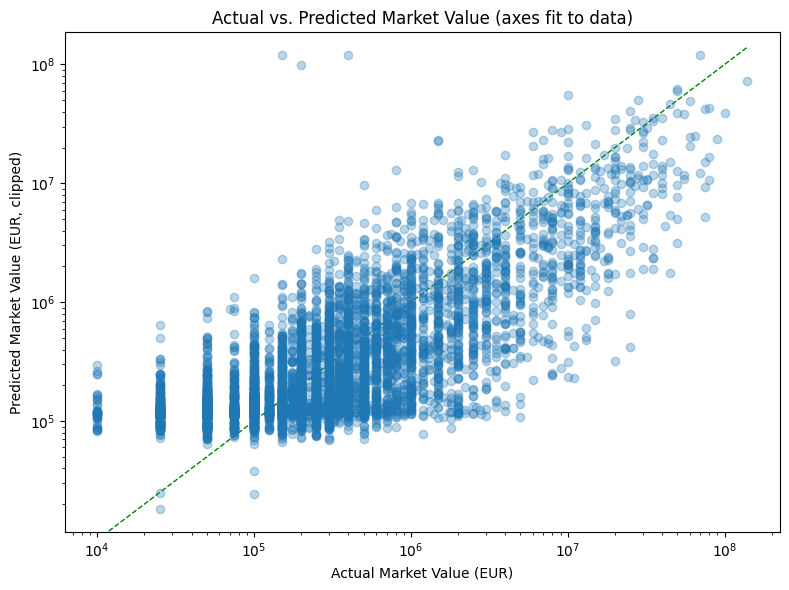

In [19]:
# Cell 7: Scatter plot of Actual vs. Predicted (real-EUR), filtering out extreme predictions

# Only plot points where predicted < €500M, so axes stay readable
limit = 3e8
mask_plot = y_pred_exp < limit

# Apply the same mask to actuals so both arrays align
x_vals = y_test_exp[mask_plot]
y_vals = y_pred_exp[mask_plot]

# Compute min and max for X and Y
x_min, x_max = x_vals.min(), x_vals.max()
y_min, y_max = y_vals.min(), y_vals.max()

# Stretch limits just a tiny bit so points on the border aren’t cut off
x_pad = (x_max / x_min) ** 0.05  
y_pad = (y_max / y_min) ** 0.05

plt.figure(figsize=(8, 6))
plt.scatter(x_vals, y_vals, alpha=0.3)

# Set log–log scale
plt.xscale('log')
plt.yscale('log')

# Set axis limits to exactly cover the data (with a tiny 1% padding)
plt.xlim(x_min / x_pad, x_max * x_pad)
plt.ylim(y_min / y_pad, y_max * y_pad)

# Draw the y = x reference line over that same range
# On a log–log plot, the diagonal line from (min, min) to (max, max) remains straight.
plt.plot(
    [x_min, x_max],
    [x_min, x_max],
    color='green',
    linewidth=1,
    linestyle='--',
    zorder=0
)

plt.xlabel("Actual Market Value (EUR)")
plt.ylabel("Predicted Market Value (EUR, clipped)")
plt.title("Actual vs. Predicted Market Value (axes fit to data)")

plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning (Quick Example)

Let’s briefly show how to tune the network size for better performance.


In [20]:
# Example: try different layer sizes
results = []
for size in [16, 32, 64, 128]:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(size, activation='relu'),
        tf.keras.layers.Dense(size, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
    y_pred = model.predict(X_test).flatten()
    y_pred_exp = np.expm1(y_pred)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    results.append((size, mae))

print("Layer size vs MAE:")
for size, mae in results:
    print(f"  {size} units: MAE = €{mae:,.2f}")


195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
Layer size vs MAE:
  16 units: MAE = €143,958,853.34
  32 units: MAE = €31,524,672.34
  64 units: MAE = €18,818,866.14
  128 units: MAE = €15,259,251.46


## 9. Feature Importance (Optional)

For neural nets, try permutation importance to see which features matter most.


## 10. Conclusions

We built a neural network model to predict football player market values using stats and personal data.  
Feel free to extend this with more advanced features, more complex models, or deeper analysis!
